In [11]:
## Import
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import open3d 
%matplotlib inline

In [12]:
import sys

python_root = '../'
sys.path.insert(0, python_root)

from tools import pathconfig
from tools import scenenet_to_rosbag, scenenet_utils

# Camera info

In [13]:
camera_model = scenenet_utils.get_camera_model()

# Read data

In [14]:
frame_id = 0
photo_id = frame_id * 25
print('frame {}'.format(frame_id))

## Read data
pySceneNetRGBD_root = pathconfig.pySceneNetRGBD_root
path_to_photos = os.path.join(pySceneNetRGBD_root, 'data/train/0/784')  # train traj 1 

path_to_lines_root = pathconfig.path_to_lines_root
path_to_lines = os.path.join(path_to_lines_root, 'lines_with_labels_{0}.txt'.format(frame_id))

path_to_lines_2D_kept = os.path.join(path_to_lines_root,
                             'lines_2D_kept_{0}.txt'.format(frame_id))
path_to_lines_2D = os.path.join(path_to_lines_root,
                             'lines_2D_{0}.txt'.format(frame_id))

data_lines = pd.read_csv(path_to_lines, sep=" ", header = None)
data_lines = data_lines.values
lines_count = data_lines.shape[0] 
print('lines number: {}'.format(lines_count))

data_lines_2D_kept = pd.read_csv(path_to_lines_2D_kept, sep=" ", header = None)
data_lines_2D_kept = data_lines_2D_kept.values
data_lines_2D_kept = data_lines_2D_kept.astype(np.int16)

data_lines_2D = pd.read_csv(path_to_lines_2D, sep=" ", header = None)
data_lines_2D = data_lines_2D.values
data_lines_2D = data_lines_2D.astype(np.int16)

assert lines_count == data_lines_2D_kept.shape[0]

rgb_image = cv2.imread(
            os.path.join(path_to_photos,'photo/{0}.jpg'.format(photo_id)), cv2.IMREAD_COLOR)

depth_image = cv2.imread(
            os.path.join(path_to_photos,'depth/{0}.png'.format(photo_id)), cv2.IMREAD_UNCHANGED)

instance_image = cv2.imread(
            os.path.join(path_to_photos,'instance/{0}.png'.format(photo_id)), cv2.IMREAD_UNCHANGED)

frame 0
lines number: 109


# Get pointcloud from rgb-d image

In [15]:
pcl = scenenet_utils.rgbd_to_pcl(rgb_image, depth_image, camera_model)

CPU times: user 52.9 ms, sys: 3.64 ms, total: 56.5 ms
Wall time: 56.3 ms


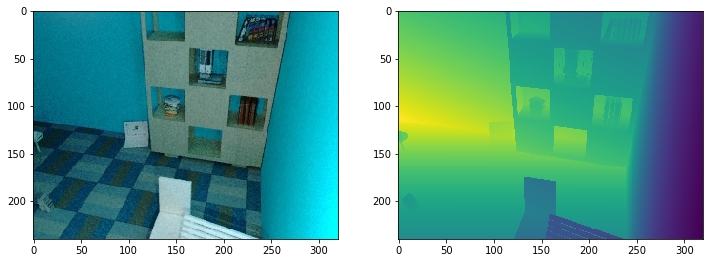

In [16]:
%%time
plt.rcParams['figure.figsize'] = (12, 12) 

image, depth = scenenet_utils.project_pcl_to_image(pcl, camera_model)
fig, ax = plt.subplots(1,2)
ax[0].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
ax[1].imshow(depth)

In [19]:
cv2.imwrite('test.png', depth.depth.astype(np.uint16))

True

In [20]:
cv2.imread('test.png', cv2.IMREAD_UNCHANGED)

array([[3842, 3839, 3835, ..., 1287, 1273, 1260],
       [3850, 3846, 3843, ..., 1286, 1272, 1258],
       [3857, 3854, 3850, ..., 1284, 1270, 1257],
       ...,
       [2924, 2924, 2924, ...,  985,  977,  969],
       [2915, 2915, 2915, ...,  984,  977,  968],
       [2905, 2905, 2906, ...,  984,  976,  967]], dtype=uint16)

# Compare all lines detected in 2D and kept lines

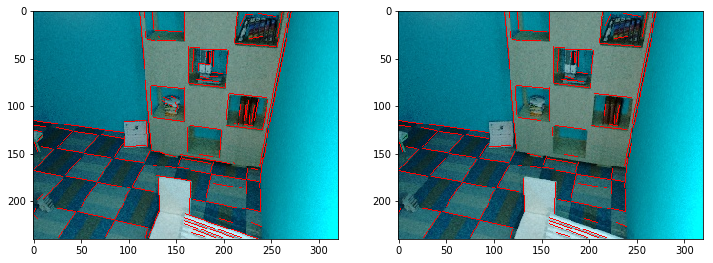

In [7]:
rgb_image_2D = cv2.imread(
            os.path.join(path_to_photos,'photo/{0}.jpg'.format(photo_id)), cv2.IMREAD_COLOR)
rgb_image_2D_kept = cv2.imread(
            os.path.join(path_to_photos,'photo/{0}.jpg'.format(photo_id)), cv2.IMREAD_COLOR)

for i in range(data_lines_2D.shape[0]):
    cv2.line(rgb_image_2D, tuple(data_lines_2D[i][:2]), tuple(data_lines_2D[i][2:]), (0,0,255), 1)
    
for i in range(data_lines_2D_kept.shape[0]):
    cv2.line(rgb_image_2D_kept, tuple(data_lines_2D_kept[i][:2]), tuple(data_lines_2D_kept[i][2:]), (0,0,255), 1)

fig, ax = plt.subplots(1,2)
ax[0].imshow(cv2.cvtColor(rgb_image_2D,cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(rgb_image_2D_kept,cv2.COLOR_BGR2RGB))

# Draw lines and pointcloud

In [8]:
pcl_open3d =  open3d.PointCloud()
pcl_open3d.points = open3d.Vector3dVector(pcl[:,:3])
pcl_open3d.colors = open3d.Vector3dVector(pcl[:,[5,4,3]]/255)

# Color line according to its type
pcl_lines_open3d = scenenet_utils.pcl_lines_for_plot(data_lines[:], data_lines[:,-3])
pcl_lines_open3d.append(pcl_open3d)
open3d.draw_geometries(pcl_lines_open3d[:])

# Vitual camera image for line

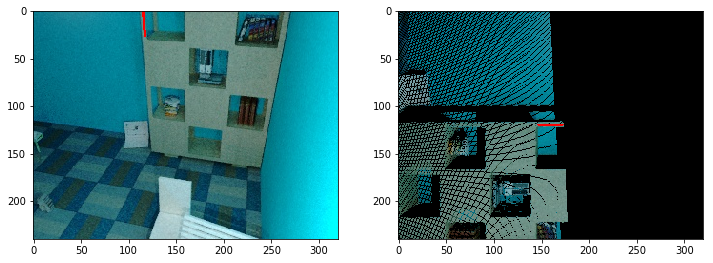

In [9]:
i = 1  # line id
distance = 3
T, z = scenenet_utils.virtual_camera_pose(data_lines[i,:], distance)

pcl_from_line_view = scenenet_utils.pcl_transform(pcl, T)
rgb_image_from_line_view, depth_image_from_line_view = scenenet_utils.project_pcl_to_image(pcl_from_line_view, camera_model)

start_point = data_lines[i,:3]
end_point = data_lines[i,3:6]
middle_point =(start_point + end_point) / 2  

pcl_line = np.vstack((start_point, end_point))
pcl_line = np.hstack((pcl_line, np.array([[0,0,255],[0,0,255]])))

pcl_line_new = scenenet_utils.pcl_transform(pcl_line, T)

cv2.line(rgb_image_from_line_view, (int(camera_model.project3dToPixel(pcl_line_new[0, :3])[0]), \
                                    int(camera_model.project3dToPixel(pcl_line_new[0, :3])[1])), \
                                   (int(camera_model.project3dToPixel(pcl_line_new[1, :3])[0]), \
                                    int(camera_model.project3dToPixel(pcl_line_new[1, :3])[1])), (0,0,255), 2)

rgb_image = cv2.imread(
            os.path.join(path_to_photos,'photo/{0}.jpg'.format(photo_id)), cv2.IMREAD_COLOR)

cv2.line(rgb_image, (int(camera_model.project3dToPixel(pcl_line[0, :3])[0]), \
                                    int(camera_model.project3dToPixel(pcl_line[0, :3])[1])), \
                                   (int(camera_model.project3dToPixel(pcl_line[1, :3])[0]), \
                                    int(camera_model.project3dToPixel(pcl_line[1, :3])[1])), (0,0,255), 2)

fig, ax = plt.subplots(1,2)
ax[0].imshow(cv2.cvtColor(rgb_image,cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(rgb_image_from_line_view,cv2.COLOR_BGR2RGB))

# Inpainting 

CPU times: user 661 ms, sys: 0 ns, total: 661 ms
Wall time: 660 ms


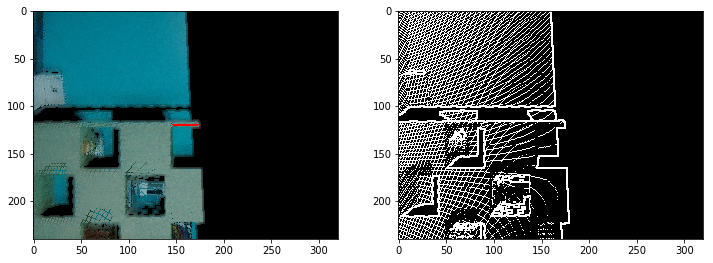

In [10]:
%%time
plt.rcParams['figure.figsize'] = (12, 12)
reds = rgb_image_from_line_view[:, :, 2]
greens = rgb_image_from_line_view[:, :, 1]
blues = rgb_image_from_line_view[:, :, 0]

mask = ((greens != 0) | (reds != 0) | (blues != 0)) * 1

mask = np.array(mask, dtype=np.uint8)

kernel = np.ones((5,5),np.uint8)
dilated_mask = cv2.dilate(mask, kernel, iterations = 1) - mask

dst_rgb = cv2.inpaint(rgb_image_from_line_view, dilated_mask, 10, cv2.INPAINT_TELEA)
dst_depth = cv2.inpaint(depth_image_from_line_view, dilated_mask, 10, cv2.INPAINT_TELEA)

permutation = np.argsort([2,1,0])
fig, ax = plt.subplots(1,2)
    
ax[0].imshow(dst_rgb[:,:,permutation])
ax[1].imshow(dilated_mask, cmap='gray')